#Майнор ИАД. Домашнее задание 3. YOLO.

В этом задании вы напишете и обучите свой собственный YOLO детектор. Нужно будет разобраться со статьей: понять какого формата должна быть обучающая пара (x, y), как перевести лосс из математической формулы в питоновский код - ну и конечно понять и реализовать саму архитектуру модели.

Выборка на котрой мы будем обучать модель состоит из разнообразных фотографий яблок, бананов и апельсинов. Данные скачиваем [отсюда](https://drive.google.com/file/d/1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3/view?usp=sharing).

Баллы за ДЗ распределены следующим образом: 
- Выборка для YoloV1 - 2 балла
- YOLO модель - 2 балла
- YOLO Loss - 3 балла
- Вспомогательные функции - 2 балла
- Обучение и расчет метрик - 2 балла

Для построения и обучения можно использовать как pytorch, так и pytorch-lightning.

Да-да, баллов в сумме получается 11

Скачаем данные

In [1]:
!wget --quiet --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://drive.google.com/uc?export=download&id=1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3" -O data.zip && rm -rf /tmp/cookies.txt
!unzip -q data.zip
!rm data.zip
!ls -l

total 12
drwx------ 4 root root 4096 Nov 26 08:32 data
drwxr-xr-x 3 root root 4096 Dec 19 20:17 __MACOSX
drwxr-xr-x 1 root root 4096 Dec 16 21:15 sample_data


Посмотрим как выглядит один из файлов разметки

In [2]:
!cat data/train/apple_3.xml

<annotation>
	<folder>train</folder>
	<filename>apple_3.jpg</filename>
	<path>C:\tensorflow1\models\research\object_detection\images\train\apple_3.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>1000</width>
		<height>708</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>1</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>584</xmin>
			<ymin>438</ymin>
			<xmax>867</xmax>
			<ymax>708</ymax>
		</bndbox>
	</object>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>492</xmin>
			<ymin>141</ymin>
			<xmax>740</xmax>
			<ymax>394</ymax>
		</bndbox>
	</object>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>176</xmin>
			<ymin>199</ymin>
			<xmax>490</xmax>
			<ymax>466</ymax>
		</bndbox>
	</object>
	<obj

In [3]:
! pip install xmltodict
! pip install pytorch_lightning
! pip install albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 800 kB 8.1 MB/s 
     |████████████████████████████████| 125 kB 74.1 MB/s 
     |████████████████████████████████| 512 kB 64.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Релизуйте выборку для YoloV1 - 2 балла

In [ ]:
import os
import cv2
import json
import glob
import tqdm
import copy
import random
import xmltodict
import gc

from IPython.core.display import struct

from typing import List

import pandas as pd
import numpy as np

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl

import albumentations as A
import albumentations.pytorch

from PIL import Image, ImageDraw

import matplotlib.pyplot as plt

from sklearn.metrics import auc

import warnings

warnings.filterwarnings("ignore")

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(777)

Так как в этом домашнем задании использовать аугментации для обучения __обязательно__ - советуем воспользоваться библиотекой albumentations.

Она  особенно удобна, поскольку умеет сама вычислять новые координаты bounding box'ов после трансформаций картинки. Для знакомства с этим механизмом советуем следующий [гайд](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/). 

Вы все еще можете избрать путь torchvision.transforms, вам потребуется знакомый нам метод `__getitem__`, однако вычислять новые координаты bounding box'ов после трансформаций вам придётся вручную

__Обратите внимание__ на то, что в статье коробки предсказаний параметризуются через: _(x_center, y_center, width, height)_ (причем эти значения _относительные_), а в наших файлах - это _(x_min, y_min, x_max, y_max)_

Также, помните что модель должна предсказывать как прямоугольник с обьектом, так и вероятности каждого класса!

In [ ]:
class2tag = {"apple": 1, "orange": 2, "banana": 3}


class FruitDataset(Dataset):
    def __init__(self, data_dir, transforms=None):
        self.image_paths = sorted(glob.glob(os.path.join(data_dir, "*.jpg")))
        self.box_paths = sorted(glob.glob(os.path.join(data_dir, "*.xml")))

        assert len(self.image_paths) == len(self.box_paths)

        self.transforms = transforms

    # Координаты прямоугольников советуем вернуть именно в формате (x_center, y_center, width, height)
    def __getitem__(self, idx):
        image = np.array(Image.open(self.image_paths[idx]).convert("RGB"))
        boxes, class_labels = self.get_boxes_from_xml(idx)

        if self.transforms:
            transformed = self.transforms(
                image=image, bboxes=boxes, class_labels=class_labels
            )
            image = transformed["image"]
            boxes, class_labels = transformed["bboxes"], transformed["class_labels"]
        return image / 255, (boxes, class_labels)

    def __len__(self):
        return len(self.image_paths)

    def get_boxes_from_xml(self, idx: int):
        """
        Метод, который считает и распарсит (с помощью xmltodict) переданный xml
        файл и вернет координаты прямоугольников обьектов на соответсвующей фотографии
        и название класса обьекта в каждом прямоугольнике

        Обратите внимание, что обьектов может быть как несколько, так и один единственный
        """
        boxes = []
        class_labels = []

        with open(self.box_paths[idx]) as fd:
            file = xmltodict.parse(fd.read())
        obj_ = file["annotation"]["object"]

        with Image.open(self.image_paths[idx]) as img:
            weight, height = img.size
        if type(obj_) == dict:
            obj_ = [obj_]
        for obj in obj_:
            coords = obj["bndbox"]
            box = [
                int(coords["xmin"]),
                int(coords["ymin"]),
                int(coords["xmax"]),
                int(coords["ymax"]),
            ]
            class_labels.append(obj["name"])
            boxes.append(self.__convert_to_yolo_box_params(box, weight, height))

        return boxes, class_labels

    def __convert_to_yolo_box_params(self, box_coordinates: List[int], im_w, im_h):
        """
        Перейти от [xmin, ymin, xmax, ymax] к [x_center, y_center, width, height].

        Обратите внимание, что параметры [x_center, y_center, width, height] - это
        относительные значение в отрезке [0, 1]

        :param: box_coordinates - координаты коробки в формате [xmin, ymin, xmax, ymax]
        :param: im_w - ширина исходного изображения
        :param: im_h - высота исходного изображения

        :return: координаты коробки в формате [x_center, y_center, width, height]
        """
        ans = []

        ans.append((box_coordinates[0] + box_coordinates[2]) / 2 / im_w)  # x_center
        ans.append((box_coordinates[1] + box_coordinates[3]) / 2 / im_h)  # y_center

        ans.append((box_coordinates[2] - box_coordinates[0]) / im_w)  # width
        ans.append((box_coordinates[3] - box_coordinates[1]) / im_h)  # height
        return ans

In [ ]:
WIDTH, HEIGHT = 448, 448

train_transform = A.Compose(
    [
        A.RandomSizedBBoxSafeCrop(height=HEIGHT, width=WIDTH),
        A.HorizontalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.RandomBrightnessContrast(p=0.4),
        A.GaussNoise(var_limit=350.0, p=0.4),
        A.pytorch.transforms.ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="yolo", label_fields=["class_labels"]),
)
test_transform = A.Compose(
    [A.Resize(height=HEIGHT, width=WIDTH), A.pytorch.transforms.ToTensorV2()],
    bbox_params=A.BboxParams(format="yolo", label_fields=["class_labels"]),
)

In [ ]:
seed_everything(777)

train_dataset = FruitDataset(transforms=train_transform, data_dir="./data/train")

val_dataset = FruitDataset(transforms=test_transform, data_dir="./data/test")
# Немного проверок, чтобы убедиться в правильности направления решения
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[0][0], torch.Tensor)
assert isinstance(train_dataset[0][1], tuple)
assert len(train_dataset[0][1]) == 2
print("Тесты успешно пройдены")

Тесты успешно пройдены


Создаем класс, выход которого - тензор размера S x S x (C + 5 * B).

In [ ]:
class FruitDatasetModified(FruitDataset):
    def __init__(self, S, B, C, data_dir, transforms=None):
        super().__init__(data_dir, transforms)
        self.S = S
        self.B = B
        self.C = C

    def __getitem__(self, idx):
        image = np.array(Image.open(self.image_paths[idx]).convert("RGB"))
        boxes, class_labels = super().get_boxes_from_xml(idx)

        if self.transforms:
            transformed = self.transforms(
                image=image, bboxes=boxes, class_labels=class_labels
            )
            image, boxes, class_labels = (
                transformed["image"],
                transformed["bboxes"],
                transformed["class_labels"],
            )
        grd = torch.zeros(self.S, self.S, self.B * 5 + self.C)

        for i in range(len(boxes)):
            x_center, y_center, width, height = boxes[i]
            class_number = class2tag[class_labels[i]] - 1
            x_grd = int(self.S * x_center)
            y_grd = int(self.S * y_center)
            x_center_0 = self.S * x_center - x_grd
            y_center_0 = self.S * y_center - y_grd
            for j in range(self.B):
                grd[y_grd, x_grd, j * 5 + self.C : (j + 1) * 5 + self.C] = torch.Tensor(
                    [x_center_0, y_center_0, width, height, 1]
                )
            grd[y_grd, x_grd, class_number] = 1
        return image / 255, grd

In [ ]:
train_dataset = FruitDatasetModified(
    S=7, B=2, C=3, transforms=train_transform, data_dir="./data/train"
)
val_dataset = FruitDatasetModified(
    S=7, B=2, C=3, transforms=test_transform, data_dir="./data/test"
)

In [ ]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=4,
    shuffle=True,
)

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=4,
    shuffle=False,
)

Считаем Intersection Over Union по 4 углам двух прямоугольников

In [ ]:
def intersection_over_union(pred_bbox, gt_bbox) -> float:
    """
    Intersection Over Union для двух прямоугольников

    :param: predicted_bbox - [x_min, y_min, x_max, y_max]
    :param: gt_bbox - [x_min, y_min, x_max, y_max]

    :return: Intersection Over Union
    """

    intersect_bbox = np.array(
        [
            max(pred_bbox[0], gt_bbox[0]),
            max(pred_bbox[1], gt_bbox[1]),
            min(pred_bbox[2], gt_bbox[2]),
            min(pred_bbox[3], gt_bbox[3]),
        ]
    )

    intersect_area = max(intersect_bbox[2] - intersect_bbox[0], 0) * max(
        intersect_bbox[3] - intersect_bbox[1], 0
    )
    area_dt = (pred_bbox[2] - pred_bbox[0]) * (pred_bbox[3] - pred_bbox[1])
    area_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    union_area = area_dt + area_gt - intersect_area

    iou = intersect_area / (union_area + 1e-7)
    return iou

IOU для батчей

In [ ]:
def intersection_over_union_for_batches(predicted_bbox, true_bbox) -> float:

    predicted_bbox = [
        predicted_bbox[..., 0:1] - predicted_bbox[..., 2:3] / 2,
        predicted_bbox[..., 1:2] - predicted_bbox[..., 3:4] / 2,
        predicted_bbox[..., 0:1] + predicted_bbox[..., 2:3] / 2,
        predicted_bbox[..., 1:2] + predicted_bbox[..., 3:4] / 2,
    ]
    true_bbox = [
        true_bbox[..., 0:1] - true_bbox[..., 2:3] / 2,
        true_bbox[..., 1:2] - true_bbox[..., 3:4] / 2,
        true_bbox[..., 0:1] + true_bbox[..., 2:3] / 2,
        true_bbox[..., 1:2] + true_bbox[..., 3:4] / 2,
    ]

    intersection_bbox = [
        torch.max(predicted_bbox[0], true_bbox[0]),
        torch.max(predicted_bbox[1], true_bbox[1]),
        torch.min(predicted_bbox[2], true_bbox[2]),
        torch.min(predicted_bbox[3], true_bbox[3]),
    ]

    intersection_area = (intersection_bbox[2] - intersection_bbox[0]).clamp(0) * (
        intersection_bbox[3] - intersection_bbox[1]
    ).clamp(0)

    area_predicted = abs(
        (predicted_bbox[2] - predicted_bbox[0])
        * (predicted_bbox[3] - predicted_bbox[1])
    )
    area_true = abs((true_bbox[2] - true_bbox[0]) * (true_bbox[3] - true_bbox[1]))

    union_area = area_predicted + area_true - intersection_area
    iou = intersection_area / (union_area + 1e-7)
    return iou

Теперь начинается основная часть домашнего задания: обучите модель YOLO для object detection на __обучающем__ датасете. 

 - Создайте модель и функцию ошибки YoloV1 прочитав [оригинальную статью](https://paperswithcode.com/paper/you-only-look-once-unified-real-time-object)
 - Напишите функцию обучения модели
 - Используйте аугментации

## Реализуйте Модель - 2 балла

Копировать точное количество слоев и параметры сверток необязательно. Главное - чтобы модель работала по принципу, описанному в статье и делала предсказание в представленном формате.


В качестве подсказки напомним, что выходом модели __для каждого обьекта__ должен быть тензор размера
__S * S * (B * 5 + С)__, где все параметры имеют такое же значение, как и в статье: 

- S - количество ячеек на которое разбивается изображение по вертикали/горизонтали
- В - количество предсказываемых прямоугольников в каждой ячейке
- 5 - количество параметров для определения каждого прямоугольника (x_center, y_center, width, height, confidence)
- С - количество классов (apple, banana, orange)

Таким образом, мы для каждого окна размера __S x S__ предсказываем __В__ коробо и один класс

In [ ]:
class CNNBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride=1,
        padding=0,
        is_max_pool: bool = False,
    ):

        super().__init__()

        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
        )
        self.batchnorm = nn.BatchNorm2d(
            out_channels
        )  # в статье еще не знали про батчнорм, но мы то из будущего ...
        self.leakyrelu = nn.LeakyReLU(0.1)

        self.is_maxpool = is_max_pool  # не после каждой свертки нужно делать maxpool
        self.maxpool = nn.MaxPool2d(2, stride=2)

    def forward(self, x):
        x = self.leakyrelu(self.batchnorm(self.conv(x)))

        if self.is_maxpool:
            x = self.maxpool(x)

        return x


class YOLO(nn.Module):
    def __init__(self, dropout=0, S=7, B=2, C=3):
        """
        :param: S * S - количество ячеек на которые разбивается изображение
        :param: B - количество предсказанных прямоугольников в каждой ячейке
        :param: C - количество классов
        """

        super(YOLO, self).__init__()
        self.dropout = dropout
        self.S = S
        self.B = B
        self.C = C
        self.model = nn.Sequential(
            CNNBlock(3, 64, 7, padding=3, stride=2, is_max_pool=True),
            CNNBlock(64, 192, 3, padding=1, is_max_pool=True),
            CNNBlock(192, 128, 1),
            CNNBlock(128, 256, 3, padding=1),
            CNNBlock(256, 256, 1),
            CNNBlock(256, 512, 3, padding=1, is_max_pool=True),
            CNNBlock(512, 256, 1),
            CNNBlock(256, 512, 3, padding=1),
            CNNBlock(512, 256, 1),
            CNNBlock(256, 512, 3, padding=1),
            CNNBlock(512, 256, 1),
            CNNBlock(256, 512, 3, padding=1),
            CNNBlock(512, 256, 1),
            CNNBlock(256, 512, 3, padding=1),
            CNNBlock(512, 512, 1),
            CNNBlock(512, 1024, 3, padding=1, is_max_pool=True),
            CNNBlock(1024, 512, 1),
            CNNBlock(512, 1024, 3, padding=1),
            CNNBlock(1024, 512, 1),
            CNNBlock(512, 1024, 3, padding=1),
            CNNBlock(1024, 1024, 3, padding=1),
            CNNBlock(1024, 1024, 3, padding=1, stride=2),
            CNNBlock(1024, 1024, 3, padding=1),
            CNNBlock(1024, 1024, 3, padding=1),
        )
        self.fc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.S * self.S * 1024, 512),
            nn.Dropout(self.dropout),
            nn.LeakyReLU(0.1),
            nn.Linear(512, self.S * self.S * (5 * self.B + self.C)),
        )

    def forward(self, x):
        x = self.model(x)
        x = self.fc_block(x)
        x = x.reshape(-1, self.S, self.S, self.B * 5 + self.C)
        return x


batch_size = 4
temp_model = YOLO()

expected_output_shape = (
    batch_size * temp_model.S * temp_model.S * (5 * temp_model.B + temp_model.C)
)

for batch_idx, (inputs, labels) in enumerate(train_dataloader):
    outputs = temp_model(inputs)
    break
assert outputs.reshape(-1).shape[0] == expected_output_shape
assert labels.reshape(-1).shape[0] == expected_output_shape

## Реализуйте YoloLoss - 3 балла

In [ ]:
class YoloLoss(nn.Module):
    def __init__(self, S=7, B=2, C=3):
        """
        :param: S * S - количество ячеек на которые разбивается изображение
        :param: B - количество предсказанных прямоугольников в каждой ячейке
        :param: C - количество классов
        """

        super().__init__()
        self.mse = nn.MSELoss(reduction="sum")

        self.S = S
        self.B = B
        self.C = C

        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):

        classification_loss = self.mse(
            target[:, :, :, 0 : self.C] * target[:, :, :, self.C + 4 : self.C + 5],
            predictions[:, :, :, 0 : self.C] * target[:, :, :, self.C + 4 : self.C + 5],
        )

        batch_size = target.size()[0]
        ious = torch.cat(
            [
                intersection_over_union_for_batches(
                    predictions[:, :, :, self.C : self.C + 4],
                    target[:, :, :, self.C : self.C + 4],
                ).unsqueeze(0),
                intersection_over_union_for_batches(
                    predictions[:, :, :, self.C + 5 : self.C + 9],
                    target[:, :, :, self.C : self.C + 4],
                ).unsqueeze(0),
            ],
            dim=0,
        )
        _, ious_max = torch.max(ious, dim=0)
        boxes = (1 - ious_max) * predictions[
            :, :, :, self.C : self.C + 5
        ] + ious_max * predictions[:, :, :, self.C + 5 : self.C + 10]

        x_loss = self.mse(
            target[:, :, :, self.C : self.C + 1]
            * target[:, :, :, self.C + 4 : self.C + 5],
            boxes[:, :, :, 0:1] * target[:, :, :, self.C + 4 : self.C + 5],
        )
        y_loss = self.mse(
            target[:, :, :, self.C + 1 : self.C + 2]
            * target[:, :, :, self.C + 4 : self.C + 5],
            boxes[:, :, :, 1:2] * target[:, :, :, self.C + 4 : self.C + 5],
        )
        w_loss = self.mse(
            torch.sqrt(target[:, :, :, self.C + 2 : self.C + 3])
            * target[:, :, :, self.C + 4 : self.C + 5],
            torch.sign(boxes[:, :, :, 2:3])
            * torch.sqrt(torch.abs(boxes[:, :, :, 2:3]))
            * target[:, :, :, self.C + 4 : self.C + 5],
        )
        h_loss = self.mse(
            torch.sqrt(target[:, :, :, self.C + 3 : self.C + 4])
            * target[:, :, :, self.C + 4 : self.C + 5],
            torch.sign(boxes[:, :, :, 3:4])
            * torch.sqrt(torch.abs(boxes[:, :, :, 3:4]))
            * target[:, :, :, self.C + 4 : self.C + 5],
        )
        localization_loss = x_loss + y_loss + w_loss + h_loss

        confidence_loss_obj = self.mse(
            boxes[:, :, :, 4:5] * target[:, :, :, self.C + 4 : self.C + 5],
            target[:, :, :, self.C + 4 : self.C + 5],
        )
        confidence_loss_nan = 0

        for i in range(self.B):
            confidence_loss_nan += self.mse(
                predictions[:, :, :, self.C + (i + 1) * 5 - 1 : self.C + (i + 1) * 5]
                * (1 - target[:, :, :, self.C + 4 : self.C + 5]),
                target[:, :, :, self.C + (i + 1) * 5 - 1 : self.C + (i + 1) * 5]
                * (1 - target[:, :, :, self.C + 4 : self.C + 5]),
            )

        return (
            self.lambda_coord * localization_loss
            + confidence_loss_obj
            + self.lambda_noobj * confidence_loss_nan
            + classification_loss
        )

## Реализуйте дополнительные функции из статьи - 2 балла

Функция, которая переводит боксы из yolo формата в оригинальный, - только для одного объекта, тогда как перед non-maximum suppression в оригинальный формат нужно перевести все боксы. Перепишем функцию: в нее будет подаваться двумерный тензор размером S*S x 5, состоящий из боксов (у каждого бокса x, y, w, h, c). Выходящие за пределы отрезка [0; 447] значения x_min, y_min, x_max и y_max загоняем в границы.

In [ ]:
def back(box, S):
    grid = torch.Tensor(S, S, 2).to(device)
    for i in range(S):
        for j in range(S):
            grid[i][j][0] = j
            grid[i][j][1] = i
    grid = grid.reshape(S * S, 2)

    w = box[:, 2:3]
    h = box[:, 3:4]
    x_c = (box[:, 0:1] + grid[:, 0:1]) / S
    y_c = (box[:, 1:2] + grid[:, 1:2]) / S

    x_min = (x_c - w / 2) * WIDTH
    x_min[x_min < 0] = 0

    x_max = (x_c + w / 2) * WIDTH
    x_max[x_max > WIDTH - 1] = WIDTH - 1

    y_min = (y_c - h / 2) * HEIGHT
    y_min[y_min < 0] = 0

    y_max = (y_c + h / 2) * HEIGHT
    y_max[y_max > HEIGHT - 1] = HEIGHT - 1

    return torch.cat((x_min, y_min, x_max, y_max, box[:, 4:5]), 1)

In [ ]:
def non_max_suppression(bbboxes, iou_threshold, threshold):
    bbboxes = sorted(
        bbboxes[bbboxes[:, 4] >= threshold], key=lambda x: x[4], reverse=True
    )
    bboxes = []
    while bbboxes:
        current_bbbox = bbboxes[0]
        bbboxes.pop(0)
        bboxes.append(current_bbbox)
        bbboxes = [
            bbbox
            for bbbox in bbboxes
            if bbbox[5] != current_bbbox[5]
            or intersection_over_union(bbbox, current_bbbox) <= iou_threshold
        ]

    return bboxes


def mean_average_precision(pred_boxes, true_boxes_intact, C, iou_threshold=0.5):
    true = [0] * C
    average_precisions = [0] * C
    for image in true_boxes_intact:
        for box in image:
            true[int(box[5])] += 1

    true_boxes = copy.deepcopy(true_boxes_intact)
    num_objects = len(pred_boxes)
    box_tensor = []
    for i in range(num_objects):
        current_pred_boxes = pred_boxes[i]
        current_true_boxes = true_boxes[i]
        for box in current_pred_boxes:
            true_box_idx = -1
            best_iou = 0
            true_positive = 0
            for j in range(len(current_true_boxes)):
                if box[5] == current_true_boxes[j][5]:
                    iou = intersection_over_union(box, current_true_boxes[j])
                    if iou > best_iou:
                        true_box_idx = j
                        best_iou = iou
            if best_iou > iou_threshold:
                current_true_boxes.pop(true_box_idx)
                true_positive = 1
            box_tensor.append(torch.Tensor([box[4], true_positive, box[5]]))
    box_tensor.sort(key=lambda x: x[0], reverse=True)

    if box_tensor:
        box_tensor = torch.stack(box_tensor, dim=0)
        classes_tensors = []

        for i in range(C):
            class_ = box_tensor[box_tensor[:, 2] == i]
            num_ground_truths = true[i]
            num_predictions = class_.size()[0]
            if num_ground_truths == 0 or num_predictions == 0:
                average_precisions[i] = 0
            else:
                cum_false_positives = torch.cumsum(1 - class_[:, 1:2], dim=0)
                cum_true_positives = torch.cumsum(class_[:, 1:2], dim=0)
                recall_curve = torch.cat(
                    (
                        torch.Tensor([0.0]),
                        (cum_true_positives / num_ground_truths).squeeze(1),
                    )
                )
                precision_curve = torch.cat(
                    (
                        torch.Tensor([1.0]),
                        (
                            cum_true_positives
                            / (cum_true_positives + cum_false_positives)
                        ).squeeze(1),
                    )
                )
                average_precisions[i] = torch.trapezoid(precision_curve, recall_curve)

        return (sum(average_precisions) / len(average_precisions)).item()

    else:
        return 0


def get_bound_boxes(loader, model, S, B, C, iou_threshold=0.5, threshold=0.4):
    model = model.to(device)
    model.eval()
    all_p_boxes = []
    all_t_boxes = []
    for batch, (inputs, labels) in enumerate(loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions_batch = model(inputs)

        batch_size = labels.size()[0]
        for i in range(batch_size):

            ground_truth = labels[i]
            predictions = predictions_batch[i]
            true_boxes_with_classes = torch.cat(
                (
                    back(ground_truth[:, :, C : C + 5].reshape(S * S, 5), S).to(device),
                    torch.argmax(
                        ground_truth[:, :, 0:C].reshape(S * S, C), dim=1
                    ).unsqueeze(-1),
                ),
                1,
            )
            true_boxes_with_classes = true_boxes_with_classes[
                true_boxes_with_classes[:, 4] == 1
            ]
            all_t_boxes.append(list(true_boxes_with_classes.cpu()))

            confidences = torch.Tensor(S, S, B).to(device)
            boxes = []

            for i in range(B):
                confidences[:, :, i : i + 1] = predictions[
                    :, :, C - 1 + (i + 1) * 5 : C + (i + 1) * 5
                ]
                boxes.append(predictions[:, :, i * 5 + C : (i + 1) * 5 + C])
            ch = back(
                (
                    torch.stack(boxes, dim=2)
                    * nn.functional.one_hot(
                        torch.argmax(confidences, dim=-1), num_classes=B
                    ).unsqueeze(dim=3)
                )
                .sum(2)
                .reshape(S * S, 5),
                S,
            )

            all_p_boxes.append(
                non_max_suppression(
                    torch.cat(
                        (
                            ch,
                            torch.argmax(
                                predictions[:, :, 0:C].reshape(S * S, C), dim=1
                            ).unsqueeze(-1),
                        ),
                        1,
                    ).cpu(),
                    iou_threshold,
                    threshold,
                )
            )

    model.train()
    return all_p_boxes, all_t_boxes

## Обучите модель и посчитайте метрики для задачи детекции - 2 балла 

Несмотря на то, что в этом блоке ничего сильно нового для вас не ожидается и за него формально дается лишь два балла - провести обучение очень важно для понимания того, насколько правильно реализована ваша модель и лосс.

В процессе обучения будет видно все ли размерности совпадают, падает ли лосс и растут ли метрики целевой задачи, поэтому на практике этот пункт гораздо оказывается гораздо важнее.

## Посчитайте метрики задачи детекции на валидационной выборке

Попробуйте понять насколько хороши ваши показатели. Если числа кажутся подозрительно низкими - возможно вам стоит перепроверить ваше решение. 

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
BATCH_SIZE = 32
S = 7
B = 2
C = 3

In [ ]:
TRAIN_OBJECTS = len(train_dataset)
VAL_OBJECTS = len(val_dataset)

In [ ]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=True,
)

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=True,
)

In [ ]:
class YOLOLearner(pl.LightningModule):
    def __init__(self, model, optimizer) -> None:
        super().__init__()

        self.model = model.to(device)
        self.loss = YoloLoss()
        self.optimizer = optimizer

    def forward(self, x) -> torch.Tensor:
        return self.model(x.to(device))

    def configure_optimizers(self):
        return self.optimizer

    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        images, target = train_batch
        loss = self.loss(self.model(images.to(device)), target)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx) -> None:
        images, target = val_batch
        loss = self.loss(self.model(images.to(device)), target)
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def training_epoch_end(self, outputs) -> None:
        all_pred_boxes, all_true_boxes = get_bound_boxes(
            train_dataloader, self.model, S, B, C
        )
        loss = (sum(output["loss"] for output in outputs) / TRAIN_OBJECTS).item()
        print("train epoch:", self.current_epoch)
        print("train loss:", loss)
        print(
            "train mean average precision:",
            mean_average_precision(all_pred_boxes, all_true_boxes, C),
        )

    def validation_epoch_end(self, outputs) -> None:
        all_pred_boxes, all_true_boxes = get_bound_boxes(
            val_dataloader, self.model, S, B, C
        )
        loss = (sum(outputs) / VAL_OBJECTS).item()
        print("val epoch:", self.current_epoch)
        print("val loss:", loss)
        print(
            "val mean average precision",
            mean_average_precision(all_pred_boxes, all_true_boxes, C),
        )

In [ ]:
seed_everything(777)

torch.cuda.empty_cache()
gc.collect()

model = YOLO(dropout=0.1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
yolo_learner = YOLOLearner(model=model, optimizer=optimizer)
trainer = pl.Trainer(accelerator=device, max_epochs=75)
trainer.fit(yolo_learner, train_dataloader, val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | YOLO     | 86.2 M
1 | loss  | YoloLoss | 0     
-----------------------------------
86.2 M    Trainable params
0         Non-trainable params
86.2 M    Total params
344.799   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

val epoch: 0
val loss: 20.938095092773438
val mean average precision 0


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

val epoch: 0
val loss: 8.639788627624512
val mean average precision 0
train epoch: 0
train loss: 23.051998138427734
train mean average precision: 0


Validation: 0it [00:00, ?it/s]

val epoch: 1
val loss: 6.549331188201904
val mean average precision 0
train epoch: 1
train loss: 10.20300579071045
train mean average precision: 0


Validation: 0it [00:00, ?it/s]

val epoch: 2
val loss: 5.839340686798096
val mean average precision 0
train epoch: 2
train loss: 7.668503284454346
train mean average precision: 0


Validation: 0it [00:00, ?it/s]

val epoch: 3
val loss: 6.53348445892334
val mean average precision 0
train epoch: 3
train loss: 7.679521083831787
train mean average precision: 0


Validation: 0it [00:00, ?it/s]

val epoch: 4
val loss: 5.856358051300049
val mean average precision 0.0009009009227156639
train epoch: 4
train loss: 6.580554962158203
train mean average precision: 0.003226685104891658


Validation: 0it [00:00, ?it/s]

val epoch: 5
val loss: 5.261852264404297
val mean average precision 0.03128194808959961
train epoch: 5
train loss: 6.2898478507995605
train mean average precision: 0.029862143099308014


Validation: 0it [00:00, ?it/s]

val epoch: 6
val loss: 5.138551235198975
val mean average precision 0.001272863824851811
train epoch: 6
train loss: 6.403916358947754
train mean average precision: 0.0015746402787044644


Validation: 0it [00:00, ?it/s]

val epoch: 7
val loss: 6.24133825302124
val mean average precision 0.010944724082946777
train epoch: 7
train loss: 6.230870246887207
train mean average precision: 0.02173265814781189


Validation: 0it [00:00, ?it/s]

val epoch: 8
val loss: 6.019565105438232
val mean average precision 0.0
train epoch: 8
train loss: 5.8350138664245605
train mean average precision: 0.002856745384633541


Validation: 0it [00:00, ?it/s]

val epoch: 9
val loss: 5.282772064208984
val mean average precision 0.12468158453702927
train epoch: 9
train loss: 5.878393173217773
train mean average precision: 0.09943610429763794


Validation: 0it [00:00, ?it/s]

val epoch: 10
val loss: 4.8713178634643555
val mean average precision 0.00028153153834864497
train epoch: 10
train loss: 5.968755722045898
train mean average precision: 0.024208569899201393


Validation: 0it [00:00, ?it/s]

val epoch: 11
val loss: 5.104617595672607
val mean average precision 0.022310743108391762
train epoch: 11
train loss: 5.497501373291016
train mean average precision: 0.025437118485569954


Validation: 0it [00:00, ?it/s]

val epoch: 12
val loss: 5.025153160095215
val mean average precision 0.05033445358276367
train epoch: 12
train loss: 5.438069820404053
train mean average precision: 0.04705415293574333


Validation: 0it [00:00, ?it/s]

val epoch: 13
val loss: 4.917725563049316
val mean average precision 0.020534005016088486
train epoch: 13
train loss: 5.11423921585083
train mean average precision: 0.03194748982787132


Validation: 0it [00:00, ?it/s]

val epoch: 14
val loss: 4.6471123695373535
val mean average precision 0.06410088390111923
train epoch: 14
train loss: 5.349432945251465
train mean average precision: 0.06398710608482361


Validation: 0it [00:00, ?it/s]

val epoch: 15
val loss: 4.552211284637451
val mean average precision 0.09915482997894287
train epoch: 15
train loss: 4.93040657043457
train mean average precision: 0.14622461795806885


Validation: 0it [00:00, ?it/s]

val epoch: 16
val loss: 4.423185348510742
val mean average precision 0.10890859365463257
train epoch: 16
train loss: 5.177862167358398
train mean average precision: 0.12475033849477768


Validation: 0it [00:00, ?it/s]

val epoch: 17
val loss: 4.387635231018066
val mean average precision 0.1144491508603096
train epoch: 17
train loss: 5.034276485443115
train mean average precision: 0.1472771018743515


Validation: 0it [00:00, ?it/s]

val epoch: 18
val loss: 4.348281383514404
val mean average precision 0.06002834439277649
train epoch: 18
train loss: 5.385165214538574
train mean average precision: 0.06752140074968338


Validation: 0it [00:00, ?it/s]

val epoch: 19
val loss: 4.380229949951172
val mean average precision 0.14844584465026855
train epoch: 19
train loss: 5.169224262237549
train mean average precision: 0.17156831920146942


Validation: 0it [00:00, ?it/s]

val epoch: 20
val loss: 4.395284175872803
val mean average precision 0.09952177852392197
train epoch: 20
train loss: 5.090921878814697
train mean average precision: 0.0717487633228302


Validation: 0it [00:00, ?it/s]

val epoch: 21
val loss: 4.438052654266357
val mean average precision 0.049402669072151184
train epoch: 21
train loss: 5.281148433685303
train mean average precision: 0.03309354558587074


Validation: 0it [00:00, ?it/s]

val epoch: 22
val loss: 4.460215091705322
val mean average precision 0.1238156259059906
train epoch: 22
train loss: 5.036647796630859
train mean average precision: 0.09545695036649704


Validation: 0it [00:00, ?it/s]

val epoch: 23
val loss: 4.275918006896973
val mean average precision 0.13483376801013947
train epoch: 23
train loss: 4.815331935882568
train mean average precision: 0.09725266695022583


Validation: 0it [00:00, ?it/s]

val epoch: 24
val loss: 4.27699089050293
val mean average precision 0.1608266830444336
train epoch: 24
train loss: 4.773003101348877
train mean average precision: 0.1388637125492096


Validation: 0it [00:00, ?it/s]

val epoch: 25
val loss: 4.081998348236084
val mean average precision 0.10143407434225082
train epoch: 25
train loss: 4.644778728485107
train mean average precision: 0.08912969380617142


Validation: 0it [00:00, ?it/s]

val epoch: 26
val loss: 3.979951858520508
val mean average precision 0.16894035041332245
train epoch: 26
train loss: 4.418566703796387
train mean average precision: 0.11707454174757004


Validation: 0it [00:00, ?it/s]

val epoch: 27
val loss: 3.9233450889587402
val mean average precision 0.15489418804645538
train epoch: 27
train loss: 4.368372440338135
train mean average precision: 0.14731340110301971


Validation: 0it [00:00, ?it/s]

val epoch: 28
val loss: 3.886354446411133
val mean average precision 0.14627985656261444
train epoch: 28
train loss: 4.399291038513184
train mean average precision: 0.1577659696340561


Validation: 0it [00:00, ?it/s]

val epoch: 29
val loss: 3.918260097503662
val mean average precision 0.14249293506145477
train epoch: 29
train loss: 4.328383922576904
train mean average precision: 0.20413745939731598


Validation: 0it [00:00, ?it/s]

val epoch: 30
val loss: 3.945737600326538
val mean average precision 0.16816408932209015
train epoch: 30
train loss: 4.253852367401123
train mean average precision: 0.19856412708759308


Validation: 0it [00:00, ?it/s]

val epoch: 31
val loss: 4.07513952255249
val mean average precision 0.1753639131784439
train epoch: 31
train loss: 4.323060512542725
train mean average precision: 0.1468227505683899


Validation: 0it [00:00, ?it/s]

val epoch: 32
val loss: 4.033646583557129
val mean average precision 0.19609485566616058
train epoch: 32
train loss: 4.2488508224487305
train mean average precision: 0.14237035810947418


Validation: 0it [00:00, ?it/s]

val epoch: 33
val loss: 3.874305248260498
val mean average precision 0.11203739792108536
train epoch: 33
train loss: 4.349059104919434
train mean average precision: 0.11647474765777588


Validation: 0it [00:00, ?it/s]

val epoch: 34
val loss: 3.7246499061584473
val mean average precision 0.20517806708812714
train epoch: 34
train loss: 4.329170227050781
train mean average precision: 0.18156230449676514


Validation: 0it [00:00, ?it/s]

val epoch: 35
val loss: 3.810985803604126
val mean average precision 0.19562454521656036
train epoch: 35
train loss: 4.128617286682129
train mean average precision: 0.27006077766418457


Validation: 0it [00:00, ?it/s]

val epoch: 36
val loss: 4.138972282409668
val mean average precision 0.16416633129119873
train epoch: 36
train loss: 4.1164937019348145
train mean average precision: 0.12933854758739471


Validation: 0it [00:00, ?it/s]

val epoch: 37
val loss: 4.052486419677734
val mean average precision 0.1245189681649208
train epoch: 37
train loss: 4.205451965332031
train mean average precision: 0.06474640965461731


Validation: 0it [00:00, ?it/s]

val epoch: 38
val loss: 3.685922384262085
val mean average precision 0.192739799618721
train epoch: 38
train loss: 4.16711950302124
train mean average precision: 0.13615189492702484


Validation: 0it [00:00, ?it/s]

val epoch: 39
val loss: 3.7862699031829834
val mean average precision 0.17113672196865082
train epoch: 39
train loss: 4.198944091796875
train mean average precision: 0.20958034694194794


Validation: 0it [00:00, ?it/s]

val epoch: 40
val loss: 3.5859081745147705
val mean average precision 0.17710433900356293
train epoch: 40
train loss: 3.9972567558288574
train mean average precision: 0.21800418198108673


Validation: 0it [00:00, ?it/s]

val epoch: 41
val loss: 3.857520818710327
val mean average precision 0.14530976116657257
train epoch: 41
train loss: 3.975398063659668
train mean average precision: 0.17332760989665985


Validation: 0it [00:00, ?it/s]

val epoch: 42
val loss: 3.732151508331299
val mean average precision 0.1511266976594925
train epoch: 42
train loss: 4.0763163566589355
train mean average precision: 0.13188864290714264


Validation: 0it [00:00, ?it/s]

val epoch: 43
val loss: 3.7305383682250977
val mean average precision 0.21150465309619904
train epoch: 43
train loss: 4.0419206619262695
train mean average precision: 0.235032320022583


Validation: 0it [00:00, ?it/s]

val epoch: 44
val loss: 3.639536142349243
val mean average precision 0.20621423423290253
train epoch: 44
train loss: 3.809213399887085
train mean average precision: 0.25336673855781555


Validation: 0it [00:00, ?it/s]

val epoch: 45
val loss: 3.5681443214416504
val mean average precision 0.22535066306591034
train epoch: 45
train loss: 3.830723285675049
train mean average precision: 0.2618153691291809


Validation: 0it [00:00, ?it/s]

val epoch: 46
val loss: 3.6059248447418213
val mean average precision 0.20024675130844116
train epoch: 46
train loss: 3.8196663856506348
train mean average precision: 0.20775167644023895


Validation: 0it [00:00, ?it/s]

val epoch: 47
val loss: 3.5512123107910156
val mean average precision 0.21624977886676788
train epoch: 47
train loss: 3.8113853931427
train mean average precision: 0.13844317197799683


Validation: 0it [00:00, ?it/s]

val epoch: 48
val loss: 3.6685214042663574
val mean average precision 0.21311093866825104
train epoch: 48
train loss: 3.915386915206909
train mean average precision: 0.0969778373837471


Validation: 0it [00:00, ?it/s]

val epoch: 49
val loss: 3.6012325286865234
val mean average precision 0.20112359523773193
train epoch: 49
train loss: 3.9151430130004883
train mean average precision: 0.20301838219165802


Validation: 0it [00:00, ?it/s]

val epoch: 50
val loss: 3.583442211151123
val mean average precision 0.21450214087963104
train epoch: 50
train loss: 3.9102871417999268
train mean average precision: 0.16564138233661652


Validation: 0it [00:00, ?it/s]

val epoch: 51
val loss: 3.4914042949676514
val mean average precision 0.22852866351604462
train epoch: 51
train loss: 3.6680595874786377
train mean average precision: 0.23581217229366302


Validation: 0it [00:00, ?it/s]

val epoch: 52
val loss: 3.414501905441284
val mean average precision 0.23508882522583008
train epoch: 52
train loss: 3.603163242340088
train mean average precision: 0.22411946952342987


Validation: 0it [00:00, ?it/s]

val epoch: 53
val loss: 3.470100164413452
val mean average precision 0.2252422571182251
train epoch: 53
train loss: 3.7401745319366455
train mean average precision: 0.27998390793800354


Validation: 0it [00:00, ?it/s]

val epoch: 54
val loss: 3.3558764457702637
val mean average precision 0.22583453357219696
train epoch: 54
train loss: 3.731977701187134
train mean average precision: 0.2762303650379181


Validation: 0it [00:00, ?it/s]

val epoch: 55
val loss: 3.299095392227173
val mean average precision 0.20506586134433746
train epoch: 55
train loss: 3.6118218898773193
train mean average precision: 0.2728271782398224


Validation: 0it [00:00, ?it/s]

val epoch: 56
val loss: 3.362577199935913
val mean average precision 0.15670792758464813
train epoch: 56
train loss: 3.662189245223999
train mean average precision: 0.23299916088581085


Validation: 0it [00:00, ?it/s]

val epoch: 57
val loss: 40.27989959716797
val mean average precision 0.01869424432516098
train epoch: 57
train loss: 3.7160966396331787
train mean average precision: 0.023645302280783653


Validation: 0it [00:00, ?it/s]

val epoch: 58
val loss: 17.141881942749023
val mean average precision 0.026697471737861633
train epoch: 58
train loss: 3.670316219329834
train mean average precision: 0.03432925418019295


Validation: 0it [00:00, ?it/s]

val epoch: 59
val loss: 4.75160551071167
val mean average precision 0.06452440470457077
train epoch: 59
train loss: 3.594926118850708
train mean average precision: 0.09807891398668289


Validation: 0it [00:00, ?it/s]

val epoch: 60
val loss: 3.6536669731140137
val mean average precision 0.13948090374469757
train epoch: 60
train loss: 3.597111701965332
train mean average precision: 0.16852958500385284


Validation: 0it [00:00, ?it/s]

val epoch: 61
val loss: 3.267469882965088
val mean average precision 0.2030622959136963
train epoch: 61
train loss: 3.484983205795288
train mean average precision: 0.2813934087753296


Validation: 0it [00:00, ?it/s]

val epoch: 62
val loss: 3.236448287963867
val mean average precision 0.24155546724796295
train epoch: 62
train loss: 3.445228099822998
train mean average precision: 0.2785118818283081


Validation: 0it [00:00, ?it/s]

val epoch: 63
val loss: 3.257963180541992
val mean average precision 0.1844760626554489
train epoch: 63
train loss: 3.512406349182129
train mean average precision: 0.27701428532600403


Validation: 0it [00:00, ?it/s]

val epoch: 64
val loss: 3.309843063354492
val mean average precision 0.23658712208271027
train epoch: 64
train loss: 3.5138509273529053
train mean average precision: 0.271716833114624


Validation: 0it [00:00, ?it/s]

val epoch: 65
val loss: 3.4409005641937256
val mean average precision 0.236031174659729
train epoch: 65
train loss: 3.3581976890563965
train mean average precision: 0.21498961746692657


Validation: 0it [00:00, ?it/s]

val epoch: 66
val loss: 3.2519187927246094
val mean average precision 0.23710469901561737
train epoch: 66
train loss: 3.502216100692749
train mean average precision: 0.2671792209148407


Validation: 0it [00:00, ?it/s]

val epoch: 67
val loss: 3.2405712604522705
val mean average precision 0.2507767975330353
train epoch: 67
train loss: 3.449986219406128
train mean average precision: 0.2030469924211502


Validation: 0it [00:00, ?it/s]

val epoch: 68
val loss: 3.2258567810058594
val mean average precision 0.1981266736984253
train epoch: 68
train loss: 3.4439096450805664
train mean average precision: 0.2775347828865051


Validation: 0it [00:00, ?it/s]

val epoch: 69
val loss: 3.1429872512817383
val mean average precision 0.2838261127471924


## Визуализируйте предсказанные bounding box'ы для любых пяти картинок из __валидационного__ датасета.

In [ ]:
def visualize(dataset, p_boxes, t_boxes, idx):
    colors = {0: "black", 1: "red", 2: "blue"}
    transform = torchvision.transforms.ToPILImage()
    img = ImageDraw.Draw(transform(dataset[idx][0]))
    for shape in p_boxes[idx]:
        img.rectangle(list(shape[0:4]), outline=colors[int(shape[5].item())])
    for shape in t_boxes[idx]:
        img.rectangle(list(shape[0:4]), outline="green")
    return transform(dataset[idx][0])

In [ ]:
all_pred_boxes, all_true_boxes = get_bound_boxes(val_dataloader, model, S=7, B=2, C=3)

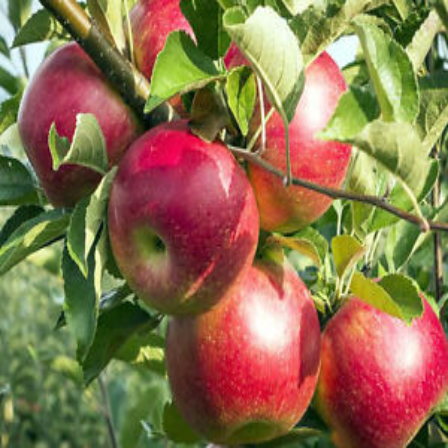

In [ ]:
visualize(val_dataset, all_pred_boxes, all_true_boxes, 0)

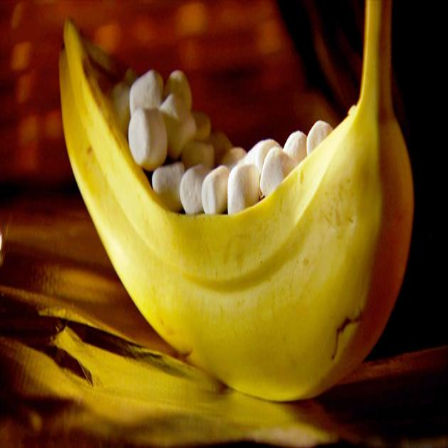

In [ ]:
visualize(val_dataset, all_pred_boxes, all_true_boxes, 25)

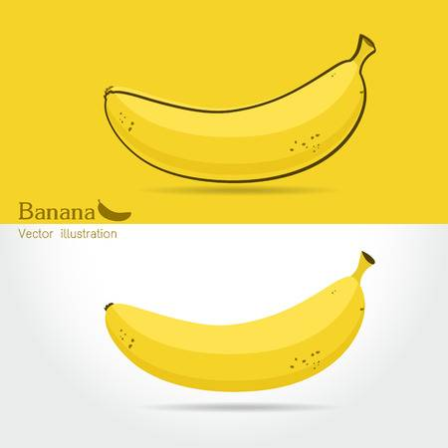

In [ ]:
visualize(val_dataset, all_pred_boxes, all_true_boxes, 35)

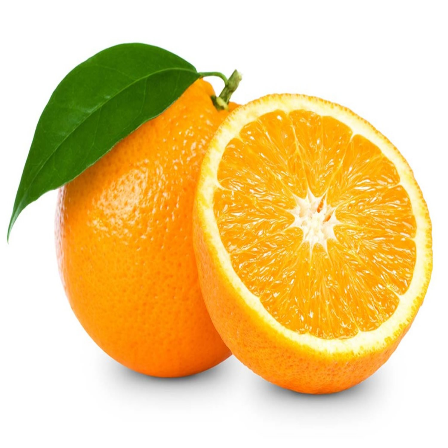

In [ ]:
visualize(val_dataset, all_pred_boxes, all_true_boxes, 45)

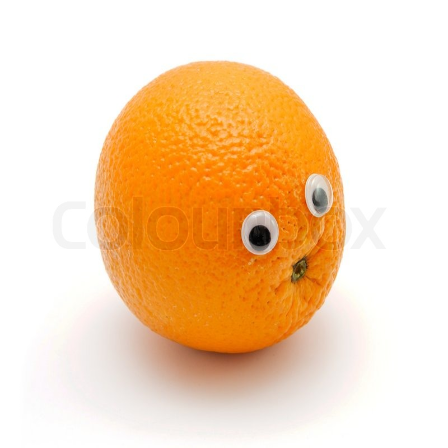

In [ ]:
visualize(val_dataset, all_pred_boxes, all_true_boxes, 55)